# Circuity Factors - Inference Model


*MIT Megacity Logistics Lab*(c)

- André Snoeck <asnoeck@mit.edu>
+ Daniel Merchan <dmerchan@mit.edu>

**This code may contain confidential and sensitive information. Please do not distribute.**

## Summary

The aim of this code is to explore different statistical models to predict the circuity factor using a specific set of predictors. After developing several different models to describe the data, we are able to evaluate the performance of those models and make a trade-off about the most appropriate model for our particular dataset.

The code can be split into two parts. 

### General functions

The first part of the code defines general functions, that are not tied to a particular dataset. Those functions are based on the methods we learned during Harvard's Data Science class, AC209a, and we aim to use those in other projects as well. 

The first set of functions are data preparation functions
- Load data
- Split data - To create a training and testing set
- Create x & y - To split the predictors and the independent variable
- Standardize data
- Polynomial transformation

The second set of functions creates different kinds of prediction models based on the test set. A general structure is followed for these models. Based on cross validation on the training set, the optimal tuning parameters are determined. As a result, the function will return the configuration of the model that best describes our data. 

We implemented the following numerical prediction models
- Linear regression
- Ridge and lasso regression (tuning parameter is alpha)
- Random forests (tuning parameters are number of trees and tree depth)

Furthermore, we implemented functions for forward and backward stepwise subset selection. 

For classification, we implemented the following models
- Logistics regression (tuning parameter is C)
- Random forests (tuning parameters are number of trees and tree depth)

Naturally, these models can be fed with different predictors, including polynomial combinations of the predictors. 

For a more in depth look at the functions for the different models, we refer to the doc strings. 

### Circuity factor application 

In this application, we use the functions described above to compare the performance of different models in terms of descriptive and predictive power. Furthermore, we will use the results of this data to analyze the effect of the different predictors that account for circuity in a pixel. 

We analyze both regression as well as classification models. Often, for network planning, practitioners will be interested in the actual value of circuity factor. However, if policy makers at the local government want to understand and influence the circuity factors and in practice it is impossible to develop urban planning initiatives for each individual pixel. A more natural way for practitioners to digest the large amount of pixels is to think of them in clusters of pixels with similar characteristics and the government will set-up different urban planning strategies for each cluster of pixels.

## Code Setup

In [1]:
#General  libraries
from __future__ import division
import numpy as np
import pandas as pd
pd.options.display.max_columns = 30
import scipy as sp
import copy

#Specific data science packages
from sklearn.linear_model import LinearRegression as Lin_Reg
from sklearn.linear_model import LogisticRegression as Log_Reg
from sklearn.linear_model import Ridge as Ridge_Reg
from sklearn.linear_model import Lasso as Lasso_Reg
from sklearn.tree import DecisionTreeRegressor as Reg_Tree
from sklearn.ensemble import RandomForestRegressor as Reg_Forest
from sklearn.ensemble import RandomForestClassifier as Cls_Forest
import statsmodels.api as sm
from statsmodels.regression.linear_model import OLS as OLS

from sklearn.preprocessing import PolynomialFeatures as PolyFeat
from sklearn.preprocessing import StandardScaler as Standardize

from sklearn.model_selection import KFold as KFold
from sklearn.model_selection import cross_val_score as CV
from sklearn.model_selection import train_test_split as Split
from sklearn.feature_selection import f_regression as RegTest

import statsmodels.api as sm
import statsmodels.formula.api as smf

#Visualization libraries
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cmx
import matplotlib.colors as colors
%matplotlib inline
import seaborn as sns

#System libraries
from itertools import combinations
import itertools as it


## Functions

### Data Preparation functions

In [2]:
def load_data(filename):
    '''
    To read the dataframe
    Input:
    - filename: variable with the name of the file to be read
    
    Output:
    - df: file converted to a pandas dataframe
    
    '''
    
    df = pd.read_csv(filename)
    return df

In [3]:
def split(df, m_test_set):
    '''
    Split a dataframe in training and testing sets. Parameter m sets the frraction of data
    allocated to the test set (suggested = 1/3 or 1/2)
    
    Input:
    - df (m x n): Dataframe of data including predictors and response variable
    - m_test_set: Fraction of data to be allocated to the testing set. 
    
    Output:
    - df_train (m x n): Dataframe for training the model 
    - df_test (m x n): Dataframe for testing the model
    '''

    df_train, df_test = Split(df, test_size = m_test_set)

    return df_train, df_test

In [4]:
def create_x_y(dataframe):
    """
    Split the dataframe into two numpy arrays with predictors and indpendent variable
    
    Input:
    - dataframe: Dataframe (m x n) with any number of predictors and one independent variable in the last column [x|y]
    
    Output:
    - x (m x (n-1)): Numpy array with predictors
    - y (m x 1):     Numpy array with independent variable 
    """
    
    x = dataframe.values[:, :-1]
    y = dataframe.values[:, -1]
    
    return x, y

In [5]:
def standardize_data(x):
    """
    Scale/standardize a matrix of (mxn) predictors. Each predictor array will be scaled to 
    zero mean and unit variance.
    
    Input: 
    - x (m x n): Numpy array with predictors 
    
    Output:
    
    - x_scaled: Standarized numpy array
    - scaler: Standarization model that can be re-used to standarize other datasets
    
    """
    
    scaler = Standardize().fit(x)
    
    x_scaled = scaler.transform(x)
    
    return x_scaled, scaler


In [6]:
def polynomial_transf(x, deg):
    
    """
    Transform a matrix of (mxn) predictors to a given polynomial degree
    
    Input: 
    - x (m x n): Numpy array with predictors 
    - deg: Desired polynomial degree
    
    Output:
    
    - x_transf: Numpy array with predictors transformend to the given polynomial degree. Includes all polynomial combinations of the features 
    with degree less than or equal to the specified degree. For example, if an input sample is two dimensional and of the form [a, b], 
    the degree-2 polynomial features are [1, a, b, a^2, ab, b^2].
    """
    
    #defining the polynomial degree
    poly = PolyFeat(deg)
    
    #trasnforming x to the desired polynomial degree
    x_transf = poly.fit_transform(x) 

    return x_transf

### Linear regression

In [7]:
def create_linear_regression_model(x, y, print_results = False):
    """
    Create linear regression model that best fits the input dataframe
    
    Input:
    - x: Dataframe (m x n) with m observations and n predictors
    - y: Dataframe (m x 1) with m observations and 1 independent variable
    
    Output:
    - lin_reg_model: Fitted linear regression model
    """
    
    # Split dataframe
    #x, y = create_x_y(dataframe)
    
    # Create linear regression model
    lin_reg_model = Lin_Reg()
    lin_reg_model.fit(x, y)
    
    # Print some results
    if print_results:
        print '\nLinear regression model created'
        print 'Train R^2: ', format(lin_reg_model.score(x, y), '.2f')
    
    return lin_reg_model

#### Ridge and Lasso regression

In [8]:
def create_regularized_regression_model(x,y, regularization_type = 'Ridge', print_results = False, visualize_results = False):
    """
    Create ridge regression model that best fits the input dataframe
    
    Input:
    - x: Dataframe (m x n) with m observations and n predictors
    - y: Dataframe (m x 1) with m observations and 1 independent variable
    - regularization_type: Either 'Ridge' or 'Lasso', default is 'Ridge'
    - print results: Optional to show best regularization parameter and associated CV and Training set scores
    - visualize_results: Optional to show best regularization parameter search
    
    Output:
    - ridge_reg_model: Fitted ridge regression model optimized for the tuning parameter lambda
    """
    
    # Split dataframe
    #x, y = create_x_y(dataframe)
    
    # Create evaluation parameter range
    min_pow_10 = -7
    max_pow_10 = 7
    reg_param_range = [ 10**i for i in range(min_pow_10, max_pow_10)]
    
    # Create list to keep track of scores
    score_train = []
    score_CV = []
    
    # Iterate over values for regression parameter
    for reg_param in reg_param_range:
        
        # Create model
        if regularization_type == 'Ridge':
            model = Ridge_Reg(alpha = reg_param)
        elif regularization_type == 'Lasso':
            model = Lasso_Reg(alpha = reg_param)
        else:
            print 'Provide either ridge or lasso'
            
        # Find cross validation score
        score_CV.append(np.mean(CV(model, x, y, cv = 5)))
        
        # Find score on training set
        model.fit(x,y)
        score_train.append(model.score(x, y))
    
    # Find highest CV score
    highest_CV_score = np.max(score_CV)
    
    # Find alpha related to highest score
    best_reg_param = reg_param_range[np.argmax(score_CV)]
    
    # Create and fit model with best regularization parameter
    if regularization_type == 'Ridge':
        model = Ridge_Reg(alpha = best_reg_param)
    elif regularization_type == 'Lasso':
        model = Lasso_Reg(alpha = best_reg_param)
    model.fit(x, y)
    
    # Print some results
    if print_results:
        print '\n', regularization_type,  'regression model created'
        print 'Best regularization parameter:', best_reg_param
        print 'Train R^2: ', format(model.score(x, y), '.2f')
        print 'CV R^2: ', format(np.max(score_CV), '.2f')
    
    # Visualize search
    if visualize_results:
        visualize_regularized_regression(score_train, score_CV, reg_param_range, regularization_type + ' regression')
    
    return model

##### Visualize regularized regression parameter search

In [9]:
def visualize_regularized_regression(train_scores, cv_scores, reg_param_range, title):
    """
    Visualize the search for the best regularization parameter
    
    Input:
    - train_scores: List with values of the model scores on the training set
    - cv_scores: List with values of the model scores for cross validation
    - reg_param_range: List with values for regression parameter
    - title: String with title above plot
    
    Output:
    - Visualization of parameter search
    """
    
    # Plot train an test R-squared as a function parameter value
    fig, ax = plt.subplots(1, 1, figsize=(6, 6))

    ax.semilogx(reg_param_range, 
                train_scores, 
                c='b', 
                label='Train scores')
    ax.semilogx(reg_param_range, 
                cv_scores, 
                c='r', 
                label='CV scores')

    ax.set_xlabel('Regularization parameter')
    ax.set_ylabel('R^2 score')
    ax.set_ylim((min(cv_scores) - 0.2, 1.2))
    ax.set_title(title)
    ax.legend(loc='best')
    
    plt.show()

#### Forward stepwise subset selection

In [10]:
def forward_stepwise_subset_selection(x, y, predictor_list, print_results = False):
    """
    Select best subset of predictors based on BIC score to find the subset of most relevant variables. 
    
    Input:
    - x: Dataframe (m x n) with m observations and n predictors
    - y: Dataframe (m x 1) with m observations and 1 independent variable
    predictor_names: List with names of predictors
    
    Output:
    - best_predictors: List of best predictors
    """
    
    predictor_names = copy.deepcopy(predictor_list)
    
    x = sm.add_constant(x, prepend=False)
    predictor_names.append('Constant')

    ### Step-wise Forward Selection
    d = x.shape[1] # total no. of predictors
    N = x.shape[0]
    
    # Keep track of current set of chosen predictors, and the remaining set of predictors
    current_predictors = [] 
    remaining_predictors = range(d)

    # Set some initial large value for min BIC score for all possible subsets
    best_r_squared = 0
    best_adjusted_r_squared = 0
        
    # Keep track of the best subset of predictors
    best_subset = [] 

    # Iterate over all possible subset sizes, 0 predictors to d predictors
    for size in range(d):    
        max_r_squared = -1e10 # set some initial small value for max R^2
        best_predictor = -1 # set some throwaway initial number for the best predictor to add
        adjusted_r_squared_with_best_predictor = 0 # set some initial large value for BIC score   

        # Iterate over all remaining predictors to find best predictor to add
        for i in remaining_predictors:
            # Make copy of current set of predictors
            temp = current_predictors[:]
            # Add predictor 'i'
            temp.append(i)

            # Use only a subset of predictors in the training data
            x_subset = x[:, temp]
            p = x_subset.shape[1]
            # Fit and evaluate R^2
            lin_reg_model = Lin_Reg()
            lin_reg_model.fit(x_subset, y)
            r_squared = lin_reg_model.score(x_subset, y)
            adjusted_r_squared = (1 - (1 - r_squared)*(N - 1)/
                                  (N - p - 1))
            
            # Check if we get a higher R^2 value than than current max R^2, if so, update
            if(r_squared > max_r_squared):
                max_r_squared = r_squared
                best_predictor = i
                adjusted_r_squared_with_best_predictor = adjusted_r_squared
                
        # Remove best predictor from remaining list, and add best predictor to current list
        remaining_predictors.remove(best_predictor)
        current_predictors.append(best_predictor)

        # Check if BIC for with the predictor we just added is lower than 
        # the global minimum across all subset of predictors
        if(adjusted_r_squared_with_best_predictor > best_adjusted_r_squared):
            best_subset = current_predictors[:]
            best_r_squared = max_r_squared
            best_adjusted_r_squared = adjusted_r_squared_with_best_predictor
    
    if print_results:
        best_predictors = [predictor_names[i] for i in best_subset]
        print 'Step-wise forward subset selection:'
        print 'Train R^2: ', format(best_r_squared, '.2f')
        print 'Predictors: ', best_predictors
    
    return best_subset # add 1 as indices start from 0

#### Backward stepwise subset selection

In [11]:
def backward_stepwise_subset_selection(x, y, predictor_list, print_results = False):
    """
    Select best subset of predictors based on BIC score to find the subset of most relevant variables. 
    
    Input:
    - x: Dataframe (m x n) with m observations and n predictors
    - y: Dataframe (m x 1) with m observations and 1 independent variable
    predictor_names: List with names of predictors
    
    Output:
    - best_predictors: List of best predictors
    """
    
    predictor_names = copy.deepcopy(predictor_list)
    
    x = sm.add_constant(x, prepend=False)
    predictor_names.append('Constant')

    ###  Step-wise Backward Selection
    d = x.shape[1] # total no. of predictors
    N = x.shape[0]
    
    # Keep track of current set of chosen predictors
    current_predictors = range(d)

    # First, fit and evaluate BIC using all 'd' number of predictors
    p = x.shape[1]

    # Fit and evaluate R^2
    lin_reg_model = Lin_Reg()
    lin_reg_model.fit(x, y)
    r_squared = lin_reg_model.score(x, y)
    adjusted_r_squared = (1 - (1 - r_squared)*(N - 1)/
                          (N - p - 1))

    # Set the minimum BIC score, initially, to the BIC score using all 'd' predictors
    # Keep track of the best subset of predictors
    best_subset = current_predictors[:] 
    best_adjusted_r_squared = adjusted_r_squared
    
    # Iterate over all possible subset sizes, d predictors to 1 predictor
    for size in range(d - 1, 1, -1): # stop before 0 to avoid choosing an empty set of predictors
        max_r_squared = -1e10 # set some initial small value for max R^2
        worst_predictor = -1 # set some throwaway initial number for the worst predictor to remove
        adjusted_r_squared_with_best_predictor = 0  # set some initial large value for min BIC score  

        # Iterate over current set of predictors (for potential elimination)
        for i in current_predictors:
            # Create copy of current predictors, and remove predictor 'i'
            temp = current_predictors[:]
            temp.remove(i)

            # Use only a subset of predictors in the training data
            x_subset = x[:, temp]
            p = x_subset.shape[1]
            
            # Fit and evaluate R^2
            lin_reg_model = Lin_Reg()
            lin_reg_model.fit(x_subset, y)
            r_squared = lin_reg_model.score(x_subset, y)
            adjusted_r_squared = (1 - (1 - r_squared)*(N - 1)/
                                  (N - p - 1))

            # Check if we get a higher R^2 value than than current max R^2, if so, update
            if(r_squared > max_r_squared):
                max_r_squared = r_squared
                worst_predictor = i
                adjusted_r_squared_with_best_predictor = adjusted_r_squared

        # Remove worst predictor from current set of predictors
        current_predictors.remove(worst_predictor)

        # Check if BIC for with the predictor we just added is lower than 
        # the global minimum across all subset of predictors
        if(adjusted_r_squared_with_best_predictor > best_adjusted_r_squared):
            best_subset = current_predictors[:]
            best_r_squared = max_r_squared
            best_adjusted_r_squared = adjusted_r_squared_with_best_predictor

    if print_results:
        best_predictors = [predictor_names[i] for i in best_subset]
        print 'Step-wise backward subset selection:'
        print 'Train R^2: ', format(best_r_squared, '.2f')
        print 'Subset of best predictors: ', best_predictors
    
    return best_subset # add 1 as indices start from 0

### Logistic regression

In [12]:
def create_logistic_regression_model(x,y, regularization_type = 'l2', print_results = False, visualize_results = False):
    """
    Create logistic regression model that best fits the input dataframe
    
    Input:
    - x: Dataframe (m x n) with m observations and n predictors
    - y: Dataframe (m x 1) with m observations and 1 independent variable
    - regularization_type: Either 'l2' or 'l1', default is 'l1'
    - print results: Optional to show best regularization parameter and associated CV and Training set scores
    - visualize_results: Optional to show best regularization parameter search
    
    Output:
    - model: Fitted logistic regression model optimized for the tuning parameter lambda
    """
    
    # Create evaluation parameter range
    min_pow_10 = -7
    max_pow_10 = 7
    reg_param_range = [ 10**i for i in range(min_pow_10, max_pow_10)]
    
    # Create list to keep track of scores
    score_train = []
    score_CV = []
    
    # Try to beat best score
    best_score = 0
    
    # Iterate over values for regression parameter
    for reg_param in reg_param_range:
        
        # Create model
        if regularization_type == 'l2':
            model = Log_Reg(penalty = regularization_type, C = reg_param)
        elif regularization_type == 'l1':
            model = Log_Reg(penalty = regularization_type, C = reg_param)
        else:
            print 'Provide either ridge or lasso'
            
        # Find cross validation score
        average_score = np.mean(CV(model, x, y, cv = 5))
        score_CV.append(np.mean(CV(model, x, y, cv = 5)))
        
        # Find score on training set
        model.fit(x,y)
        score_train.append(model.score(x, y))
        
        if average_score > best_score:
            best_score = average_score
            best_reg_param = reg_param
            
    #     # Find highest CV score
    #     highest_CV_score = np.max(score_CV)

    #     # Find alpha related to highest score
    #     best_reg_param = reg_param_range[np.argmax(score_CV)]

    # Create and fit model with best regularization parameter
        if regularization_type == 'l2':
            model = Log_Reg(penalty = regularization_type, C = best_reg_param)
        elif regularization_type == 'l1':
            model = Log_Reg(penalty = regularization_type, C = best_reg_param)
    model.fit(x, y)
    
    # Print some results
    if print_results:
        print '\n', regularization_type,  'regression model created'
        print 'Best regularization parameter:', best_reg_param
        print 'Train R^2: ', format(model.score(x, y), '.2f')
        print 'CV R^2: ', format(best_score, '.2f')
    
    # Visualize search
    if visualize_results:
        visualize_regularized_regression(score_train, score_CV, reg_param_range, regularization_type + ' regression')
    
    return model

### Random Forest - Regression

In [13]:
def create_random_forest_regression_model(x, y, print_results = False):
    """
    Create random forest model that best fits the x and y dataframe
    
    Input:
    - x: Dataframe (m x n) with m observations and n predictors
    - y: Dataframe (m x 1) with m observations and 1 independent variable
    - print results: Optional to show best regularization parameter and associated CV and Training set scores
    
    Output:
    - model: Fitted random forest model optimized for the tuning parameters number of trees and tree depth
    """
    
    # Create evaluation parameter range    
    n_trees = np.arange(10, 150, 20)  # Trees and depth are explored on an exponentially growing space,
    depths = np.arange(2, 10)   # since it is assumed that trees and depth will add accuracy in a decaying fashion.

    # Create list to keep track of scores
    score_train = []
    score_CV = []
    
    # Keep track of current best score
    best_score = 0
    
    # Iterate over number of trees
    for trees in n_trees:
        
        # Iterete over different depths
        for depth in depths:
            
            # Create random forest model
            model = Reg_Forest(n_estimators = trees, max_depth = depth)

            # Get cross validation score 
            average_score = np.mean(CV(model, x, y, cv = 5))
            
            if average_score > best_score:
                best_score = average_score
                best_depth = depth
                best_trees = trees
           
    # Recreate best model and fit it using the whole training data
    model = Reg_Forest(n_estimators = best_trees, max_depth = best_depth)
    
    # Fit model using entire training set
    model.fit(x,y)
    
    # Print some results
    if print_results:
        print '\n Random Forest Model created'
        print 'Best number of trees: ', best_trees
        print 'Best depth: ', best_depth
        print 'Train R^2: ', format(model.score(x, y), '.2f')
        print 'CV R^2: ', format(best_score, '.2f')
    
    return model

### Random Forest -  Classification

In [14]:
def create_random_forest_classification_model(x, y, print_results = False):
    """
    Create random forest model that best fits the x and y dataframe
    
    Input:
    - x: Dataframe (m x n) with m observations and n predictors
    - y: Dataframe (m x 1) with m observations and 1 independent variable
    - print results: Optional to show best regularization parameter and associated CV and Training set scores
    
    Output:
    - model: Fitted random forest model optimized for the tuning parameters number of trees and tree depth
    """
    
    # Create evaluation parameter range    
    n_trees = np.arange(10, 150, 20)  # Trees and depth are explored on an exponentially growing space,
    depths = np.arange(2, 10)   # since it is assumed that trees and depth will add accuracy in a decaying fashion.

    # Create list to keep track of scores
    score_train = []
    score_CV = []
    
    # Keep track of current best score
    best_score = 0
    
    # Iterate over number of trees
    for trees in n_trees:
        
        # Iterete over different depths
        for depth in depths:
            
            # Create random forest model
            model = Cls_Forest(n_estimators = trees, max_depth = depth)

            # Get cross validation score 
            average_score = np.mean(CV(model, x, y, cv = 5))
            
            if average_score > best_score:
                best_score = average_score
                best_depth = depth
                best_trees = trees
           
    # Recreate best model and fit it using the whole training data
    model = Cls_Forest(n_estimators = best_trees, max_depth = best_depth)
    
    # Fit model using entire training set
    model.fit(x,y)
    
    # Print some results
    if print_results:
        print '\n Random Forest Model created'
        print 'Best number of trees: ', best_trees
        print 'Best depth: ', best_depth
        print 'Train R^2: ', format(model.score(x, y), '.2f')
        print 'CV R^2: ', format(best_score, '.2f')
    
    return model

#### Visualize features

In [15]:
def create_importance_features_list(random_forest_model, x_columns, visualize_results = False, title = 'Relative importance of Each Feature'):
    """
    Create a list of most important features for the random forest
    
    Input:
    - random_forest_model: a fitted random forest model
    - x_columns: names of the columns of the fitted dataframe
    - visualize_results: Optional to show graph of most imortant features
    - title: String with title above plot
    
    Output:
    - features_list: Dataframe of features and relative importance
    - Optional: Visualization of features
    """ 
    
    # Create importance list
    features_list = random_forest_model.feature_importances_
    
    # Get matching column names
    name_list = x_columns
    
    features_list, name_list = zip(*sorted(zip(features_list, name_list)))
    plt.figure(figsize = (8,8))
    plt.barh(range(len(name_list)), features_list, align='center')
    plt.yticks(range(len(name_list)), name_list)
    plt.xlabel('Relative Importance in the Random Forest')
    plt.ylabel('Predictor')
    plt.title(title)
    plt.show()
    
#     importance_list_df = pd.DataFrame(data = features_list, columns = ['Importance'], index = name_list)
    
#     return importance_list_df.sort_values('Importance')

## Model Execution

### Data preparation

#### Load data

In [16]:
pixels_file = 'SP_pixel_list_cf_predictors_v2_categories.csv'
# pixels_file = 'SFO_BayArea_pixel_list_cf_predictors.csv'
pixels_data_df = load_data(pixels_file)
pixels_data_df.head()
pixels_data_df.columns.values

array(['pixel_ID', 'lat', 'lon', 'cf', 'directionality', 'population',
       'road_connectivity', 'road_capacity', 'road_capacity_incl_highway',
       'road_capacity_highway', 'road_distance',
       'road_distance_incl_highway', 'road_distance_highway',
       'oneway_distance', 'oneway_dist_percentage', 'oneway_capacity',
       'oneway_percentage', 'highway_bin', 'bridge_bin', 'tunnel_bin',
       'rail_bin', 'waterway_bin', 'waterway_distance', 'cf_category'], dtype=object)

#### Regression indicator

Since we have implemented both regression as well classification functions, we have specified a parameter that serves as indicator if the regression or the classification models should be run. This depends on the input dataset used. 

In [17]:
#Extract relevant columns (predictors and response variable only)
regression = True

#### Predictor selection

Based on this regression flag, we determine what predictors we include in our analysis. This subset of predictors is chosen to account for multicollinearity issues. Obviously, the independent variable is different in the cases of regression and classification. 

In [18]:
if regression:

    xy_df = pixels_data_df[['population',
                            'road_connectivity', 
                            'road_capacity','road_capacity_highway', 
                            'road_distance','road_distance_highway',
                            'oneway_distance',
                            'bridge_bin', 'tunnel_bin',
                            'rail_bin', 'waterway_distance', 'cf']]
else:

    xy_df = pixels_data_df[['population',
                            'road_connectivity', 
                            'road_capacity','road_capacity_highway', 
                            'road_distance','road_distance_highway',
                            'oneway_distance',
                            'bridge_bin', 'tunnel_bin',
                            'rail_bin', 'waterway_distance', 'cf_category']]

# Rename columns
xy_df.columns = ['Population',
                     'Road Connectivity', 
                     'Road Capacity','Highway Capacity', 
                     'Road Distance','Highway Distance',
                     'One-Way Distance',
                     'Bridge', 
                     'Tunnel',
                     'Rail', 
                     'Waterway Distance', 'Circuity Factor']

xy_df.head()

,Population,Road Connectivity,Road Capacity,Highway Capacity,Road Distance,Highway Distance,One-Way Distance,Bridge,Tunnel,Rail,Waterway Distance,Circuity Factor
0,0,12,19.721551,0.000000,10.780871,0.000000,0.559462,0,0,0,0.0,2.640166
1,0,8,67.709612,0.648042,18.681803,0.648042,0.000000,0,0,0,0.0,1.371079
2,0,0,0.000000,65.370412,0.000000,16.342603,0.000000,0,0,0,0.0,1.532384
3,0,0,0.000000,0.000000,0.000000,0.000000,0.000000,0,0,0,0.0,3.292541
4,0,0,0.000000,65.370412,0.000000,16.342603,0.000000,0,0,0,0.0,2.677605


In [19]:
# Create list of predictor names
predictors = list(xy_df.columns.values)
predictors = predictors[:-1]
print 'Predictors List'
print predictors

Predictors List
['Population', 'Road Connectivity', 'Road Capacity', 'Highway Capacity', 'Road Distance', 'Highway Distance', 'One-Way Distance', 'Bridge', 'Tunnel', 'Rail', 'Waterway Distance']


#### Filter pixels

Since we are analyzing the circuity factor in urban areas, we only want to include urban areas in our analysis. Therefore, we filter pixels that don't exceed a certain population bound. We also exclude pixels that do not have any roads or intersections for obvious reasons. 

In [20]:
# Set filters
# Set filter columns and respective values
filter_columns = ['Population', 'Road Distance', 'Road Connectivity']
filter_values = [ 5000, 0, 0]

# Iterate over all columns with a minimum filter
for i in range(len(filter_values)):
    print 'Filter data based on: ', filter_columns[i], ' - threshold value: ', filter_values[i]
    xy_df = xy_df[xy_df[filter_columns[i]] > filter_values[i]]

print 'Observations after filtering: ', len(xy_df)


Filter data based on:  Population  - threshold value:  5000
Filter data based on:  Road Distance  - threshold value:  0
Filter data based on:  Road Connectivity  - threshold value:  0
Observations after filtering:  1365


#### Split data

Split the data set in train and test sets

In [21]:
xy_train, xy_test = split(xy_df, 1/3)
print 'Observations in (training, testing) set: ', len(xy_train), ',', len(xy_test)
# xy_train.head()



Observations in (training, testing) set:  910 , 455


In [22]:
#Extract x and y
x_train, y_train = create_x_y(xy_train)
x_test, y_test = create_x_y(xy_test)

#Standarize the data
x_train_std, scaler = standardize_data(x_train)
x_test_std = scaler.transform(x_test)

#### Initialize a matrix to keep track of model results

In [23]:
# Create matrix to keep track of model scores
# For each regression model, track: Model_type, R^2 train, R^2 test, key_paramters
# For each regression model, track: Model_type, accuracy train, accuracy test, key_paramters

model_results_matrix = []

## Run Models

### Linear Regression Model

In [24]:
# Only run model in case of regression
if regression:
    lin_reg_model = create_linear_regression_model(x_train, y_train, print_results = True)
    print 'Test R^2:  ', format(lin_reg_model.score(x_test, y_test), '0.2f')
    # Append model results to model results matrix
    model_results_matrix.append([
            'Linear Regression (No Standardization)', 
            lin_reg_model.score(x_train, y_train),
            lin_reg_model.score(x_test, y_test),
            ''
        ])

# Only run model in case of regression
if regression:
    lin_reg_model = create_linear_regression_model(x_train_std, y_train, print_results = True)
    print 'Test R^2:  ', format(lin_reg_model.score(x_test_std, y_test), '0.2f')
    # Append model results to model results matrix
    model_results_matrix.append([
            'Linear Regression', 
            lin_reg_model.score(x_train_std, y_train),
            lin_reg_model.score(x_test_std, y_test),
            ''
        ])


Linear regression model created
Train R^2:  0.43
Test R^2:   0.43

Linear regression model created
Train R^2:  0.43
Test R^2:   0.43


#### Validation with StatsModel

In [25]:
print 'Predictors List'
print [predictor for predictor in predictors]

Predictors List
['Population', 'Road Connectivity', 'Road Capacity', 'Highway Capacity', 'Road Distance', 'Highway Distance', 'One-Way Distance', 'Bridge', 'Tunnel', 'Rail', 'Waterway Distance']


In [26]:
x_train_sm = sm.add_constant(x_train_std)
validation = OLS(y_train, x_train_sm).fit()
# print validation.summary()
# validation.rsquared

#### Forward stepwise subset selection

In [27]:
# Only run model in case of regression
if regression:
    # Select best predictors
    forward_predictors = forward_stepwise_subset_selection(x_train_std, y_train, predictors, print_results = True)
    
    # Run model with best predictors
    lin_reg_model = create_linear_regression_model(x_train_std[:, forward_predictors], y_train, print_results = True)
    print 'Test R^2:  ', format(lin_reg_model.score(x_test_std[:, forward_predictors], y_test), '0.2f')
    # Append model results to model results matrix
    model_results_matrix.append([
            'Forward Stepwise Regression', 
            lin_reg_model.score(x_train_std[:, forward_predictors], y_train),
            lin_reg_model.score(x_test_std[:, forward_predictors], y_test),
            'Number of predictors: ' + str(len(forward_predictors))
        ])

Step-wise forward subset selection:
Train R^2:  0.43
Predictors:  ['Road Connectivity', 'Highway Distance', 'Bridge', 'Road Distance', 'Road Capacity', 'Population', 'Rail', 'Waterway Distance', 'Tunnel', 'Highway Capacity']

Linear regression model created
Train R^2:  0.43
Test R^2:   0.43


#### Backward stepwise subset selection

In [28]:
# Only run model in case of regression
if regression:
    # Select best predictors
    backward_predictors = backward_stepwise_subset_selection(x_train_std, y_train, predictors, print_results = True)

    # Run model with best predictors
    lin_reg_model = create_linear_regression_model(x_train_std[:, backward_predictors], y_train, print_results = True)
    print 'Test R^2:  ', format(lin_reg_model.score(x_test_std[:, backward_predictors], y_test), '0.2f')
    # Append model results to model results matrix
    model_results_matrix.append([
            'Backward Stepwise Regression', 
            lin_reg_model.score(x_train_std[:, backward_predictors], y_train),
            lin_reg_model.score(x_test_std[:, backward_predictors], y_test),
            'Number of predictors: ' + str(len(backward_predictors))
        ])

Step-wise backward subset selection:
Train R^2:  0.43
Subset of best predictors:  ['Population', 'Road Connectivity', 'Road Capacity', 'Highway Capacity', 'Road Distance', 'Highway Distance', 'Bridge', 'Tunnel', 'Rail', 'Waterway Distance']

Linear regression model created
Train R^2:  0.43
Test R^2:   0.43


### Quadratic Linear Regression Model

In [29]:
# Create polynomial terms
x_train_transf = polynomial_transf(x_train_std, 2)
x_test_transf = polynomial_transf(x_test_std, 2)

In [30]:
# Only run model in case of regression
if regression:
    # Run polynomial model
    poly_reg_model = create_linear_regression_model(x_train_transf, y_train, print_results = True)
    print 'Test R^2:  ', format(poly_reg_model.score(x_test_transf, y_test), '0.2f')
    # Append model results to model results matrix
    model_results_matrix.append([
            'Polynomial Regression - ' + str(2), 
            poly_reg_model.score(x_train_transf, y_train),
            poly_reg_model.score(x_test_transf, y_test),
            ''
        ])



Linear regression model created
Train R^2:  0.51
Test R^2:   0.31


#### Forward stepwise subset selection

In [31]:
# Only run model in case of regression
if regression:
    # Select best predictors
    forward_predictors = forward_stepwise_subset_selection(x_train_transf, y_train, predictors, print_results = False)
    
    # Run model with best predictors
    lin_reg_model = create_linear_regression_model(x_train_transf[:, forward_predictors], y_train, print_results = True)
    print 'Test R^2:  ', format(lin_reg_model.score(x_test_transf[:, forward_predictors], y_test), '0.2f')
    # Append model results to model results matrix
    model_results_matrix.append([
            'Forward Stepwise Polynomial Regression', 
            lin_reg_model.score(x_train_transf[:, forward_predictors], y_train),
            lin_reg_model.score(x_test_transf[:, forward_predictors], y_test),
            'Number of predictors: ' + str(len(forward_predictors))
        ])


Linear regression model created
Train R^2:  0.50
Test R^2:   0.31


#### Backward stepwise subset selection

In [32]:
# Only run model in case of regression
if regression:
    # Select best predictors
    backward_predictors = backward_stepwise_subset_selection(x_train_transf, y_train, predictors, print_results = False)

    # Run model with best predictors
    lin_reg_model = create_linear_regression_model(x_train_transf[:, backward_predictors], y_train, print_results = True)
    print 'Test R^2:  ', format(lin_reg_model.score(x_test_transf[:, backward_predictors], y_test), '0.2f')
    # Append model results to model results matrix
    model_results_matrix.append([
            'Backward Stepwise Polynomial Regression', 
            lin_reg_model.score(x_train_transf[:, backward_predictors], y_train),
            lin_reg_model.score(x_test_transf[:, backward_predictors], y_test),
            'Number of predictors: ' + str(len(backward_predictors))
        ])


Linear regression model created
Train R^2:  0.50
Test R^2:   0.32


####  Ridge regression

In [33]:
# Only run model in case of regression
if regression:
    ridge_poly_reg_model = create_regularized_regression_model(x_train_transf, y_train, regularization_type = 'Ridge', print_results = True, visualize_results = False)
    print 'Test R^2:  ', format(ridge_poly_reg_model.score(x_test_transf, y_test), '0.2f')
    # Append model results to model results matrix
    model_results_matrix.append([
            'Polynomial Ridge Regression - ' + str(2), 
            ridge_poly_reg_model.score(x_train_transf, y_train),
            ridge_poly_reg_model.score(x_test_transf, y_test),
            'alpha: ' + str(ridge_poly_reg_model.alpha)
        ])


Ridge regression model created
Best regularization parameter: 100
Train R^2:  0.47
CV R^2:  0.35
Test R^2:   0.37


#### Lasso regression

In [34]:
# Only run model in case of regression
if regression:
    lasso_poly_reg_model = create_regularized_regression_model(x_train_transf, y_train, regularization_type = 'Lasso', print_results = True, visualize_results = False)
    print 'Test R^2:  ', format(lasso_poly_reg_model.score(x_test_transf, y_test), '0.2f')
    # Append model results to model results matrix
    model_results_matrix.append([
            'Polynomial Lasso Regression - ' + str(2), 
            lasso_poly_reg_model.score(x_train_transf, y_train),
            lasso_poly_reg_model.score(x_test_transf, y_test),
            'alpha: ' + str(lasso_poly_reg_model.alpha)
        ])

//anaconda/lib/python2.7/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)



Lasso regression model created
Best regularization parameter: 0.01
Train R^2:  0.47
CV R^2:  0.38
Test R^2:   0.39




##### Validation with StatsModel

In [35]:
print 'Predictors List'
print [predictor for predictor in predictors]

Predictors List
['Population', 'Road Connectivity', 'Road Capacity', 'Highway Capacity', 'Road Distance', 'Highway Distance', 'One-Way Distance', 'Bridge', 'Tunnel', 'Rail', 'Waterway Distance']


In [36]:
# x_train_transf_sm = sm.add_constant(x_train_transf)
validation_poly = OLS(y_train, x_train_transf).fit()
# print validation_poly.summary()

#### No Standarization

In [37]:
# Create non standardized polynomial predictors
x_train_transf_nostd = polynomial_transf(x_train, 2)
x_test_transf_nostd = polynomial_transf(x_test, 2)

# Only run model in case of regression
if regression:
    # Run polynomial model
    poly_reg_model_nostd = create_linear_regression_model(x_train_transf_nostd, y_train, print_results = True)
    print 'Test R^2:  ', format(poly_reg_model_nostd.score(x_test_transf_nostd, y_test), '0.2f')
    # Append model results to model results matrix
    model_results_matrix.append([
            'Polynomial Regression (Non Standardization) - ' + str(2), 
            poly_reg_model_nostd.score(x_train_transf_nostd, y_train),
            poly_reg_model_nostd.score(x_test_transf_nostd, y_test),
            ''
        ])


Linear regression model created
Train R^2:  0.51
Test R^2:   0.31


In [38]:
validation_poly_nostd = sm.OLS(y_train, x_train_transf_nostd).fit()
# print validation_poly_nostd.summary()

### Logistic Regression Model

In [39]:
# Only run model in case of classification
if not regression:
    log_reg_model = create_logistic_regression_model(x_train_std, y_train, regularization_type='l2', print_results = True)
    print 'Test R^2:  ', format(log_reg_model.score(x_test_std, y_test), '0.2f')
    # Append model results to model results matrix
    model_results_matrix.append([
            'Logistic Regression - Std', 
            log_reg_model.score(x_train_std, y_train),
            log_reg_model.score(x_test_std, y_test),
            'C: ' + str(log_reg_model.C)
        ])

### Quadratic Logistic Regression Model

In [40]:
# Only run model in case of classification
if not regression:
    poly_log_reg_model = create_logistic_regression_model(x_train_transf, y_train, regularization_type='l2', print_results = True)
    print 'Test R^2:  ', format(poly_log_reg_model.score(x_test_transf, y_test), '0.2f')
    # Append model results to model results matrix
    model_results_matrix.append([
            'Polynomial Logistic Regression - ' + str(2),
            poly_log_reg_model.score(x_train_transf, y_train),
            poly_log_reg_model.score(x_test_transf, y_test),
            'C: ' + str(poly_log_reg_model.C)
        ])

### Random forest model - No Standarization

In [41]:
# Only run model in case of classification
if not regression:
    forest_cls_model_nostd = create_random_forest_classification_model(x_train, y_train, print_results = True)
    print 'Test R^2:  ', format(forest_cls_model_nostd.score(x_test, y_test), '0.2f')
    features_list_cls = create_importance_features_list(forest_cls_model_nostd, predictors, visualize_results = True, title = 'Relative importance of Predictors')
    # Append model results to model results matrix
    model_results_matrix.append([
            'Random Forest Classification', 
            forest_cls_model_nostd.score(x_train, y_train),
            forest_cls_model_nostd.score(x_test, y_test),
            'trees, depth: ' + str(forest_cls_model_nostd.n_estimators) + ',' + str(forest_cls_model_nostd.max_depth)
        ])

In [42]:
# print forest_cls_model_nostd.feature_importances_
# predictors


 Random Forest Model created
Best number of trees:  90
Best depth:  7
Train R^2:  0.76
CV R^2:  0.42
Test R^2:   0.33


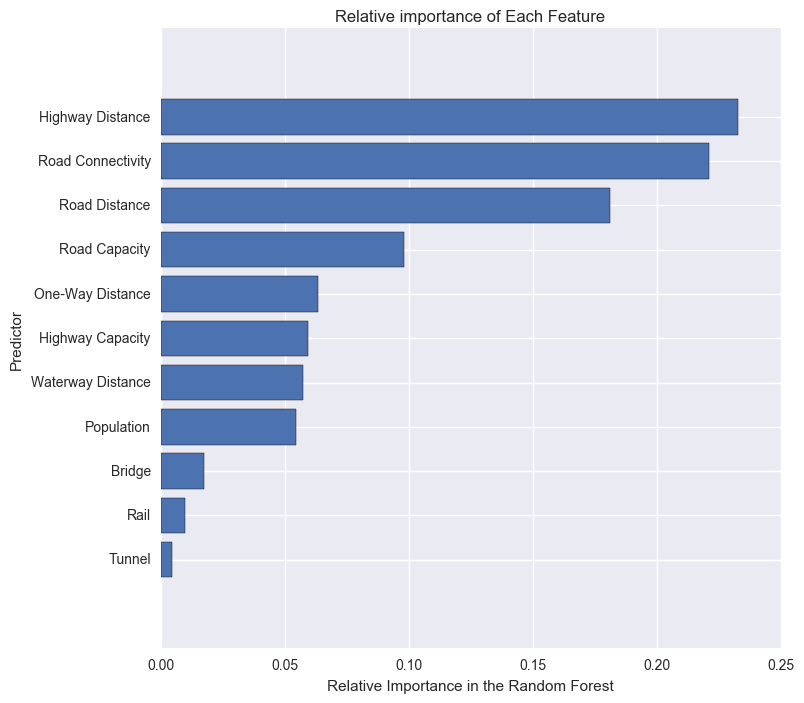

In [43]:
# Only run model in case of regression
if regression:
    forest_reg_model_nostd = create_random_forest_regression_model(x_train, y_train, print_results = True)
    print 'Test R^2:  ', format(forest_reg_model_nostd.score(x_test, y_test), '0.2f')
    features_list_reg = create_importance_features_list(forest_reg_model_nostd, predictors, visualize_results = True, title = 'Relative importance of Each Feature')
    # Append model results to model results matrix
    model_results_matrix.append([
            'Random Forest Regression', 
            forest_reg_model_nostd.score(x_train, y_train),
            forest_reg_model_nostd.score(x_test, y_test),
            'trees, depth: ' + str(forest_reg_model_nostd.n_estimators) + ',' + str(forest_reg_model_nostd.max_depth)
        ])

In [44]:
test_scores = pd.DataFrame(data = model_results_matrix, columns = ['Model', 'Train Score', 'Test Score', 'Relevant Parameters'])
test_scores

,Model,Train Score,Test Score,Relevant Parameters
0,Linear Regression (No Standardization),0.434377,0.428022,
1,Linear Regression,0.434377,0.428022,
2,Forward Stepwise Regression,0.433912,0.427306,Number of predictors: 10
3,Backward Stepwise Regression,0.433912,0.427306,Number of predictors: 10
4,Polynomial Regression - 2,0.506048,0.309171,
5,Forward Stepwise Polynomial Regression,0.502224,0.309727,Number of predictors: 49
6,Backward Stepwise Polynomial Regression,0.500897,0.320743,Number of predictors: 42
7,Polynomial Ridge Regression - 2,0.469893,0.370441,alpha: 100
8,Polynomial Lasso Regression - 2,0.472965,0.391058,alpha: 0.01
9,Polynomial Regression (Non Standardization) - 2,0.506048,0.309142,


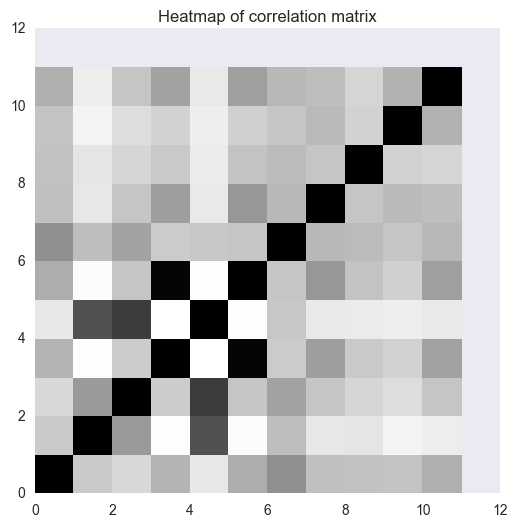

In [45]:
# Compute matrix of correlation coefficients
corr_matrix = np.corrcoef(x_train.T)

# Display heat map 
fig, ax = plt.subplots(1, 1, figsize=(6, 6))

ax.pcolor(corr_matrix)

ax.set_title('Heatmap of correlation matrix')

plt.show()
